## Fine-tuning Automatic Speech Recognition (ASR) Model
- **Model:** "wav2vec2-large-960h", https://huggingface.co/facebook/wav2vec2-large-960h
- *Read up on articles on Fine-tuning, Loss function and Evaluation matrix (WEP etc.)*

**Research Papers & Useful links**
- **Wave2Vec 2.0**: https://arxiv.org/pdf/2006.11477
- **Model Framework (Intuition, Architecture, Loss, Fine-tuning)**: https://towardsdatascience.com/wav2vec-2-0-a-framework-for-self-supervised-learning-of-speech-representations-7d3728688cae/
- **Source code:** https://github.com/huggingface/transformers/blob/v4.49.0/src/transformers/training_args.py#L224
- **Contrastive learning in pre-training:** https://towardsdatascience.com/wav2vec-2-0-a-framework-for-self-supervised-learning-of-speech-representations-7d3728688cae/
- **Connectionist Temporal Classification (CTC) for sequence modelling and fine-tuning:** https://distill.pub/2017/ctc/
- **Fine-tuning wav2vec for ASR with timit dataset:** https://huggingface.co/blog/fine-tune-wav2vec2-english
- **List of Evaluation Metrics for ASR models:** https://huggingface.co/learn/audio-course/chapter5/evaluation
- **Common voice dataset card:** https://huggingface.co/datasets/legacy-datasets/common_voice/blob/main/README.md#dataset-summary

In [ ]:
# for google colab - Mount Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install datasets evaluate ray loguru jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
# Import dependencies
import os
import io
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import torchaudio
import torch
from datasets import load_dataset, Dataset, DatasetDict, Audio
import evaluate
from transformers import (Wav2Vec2Processor, Wav2Vec2ForCTC, Trainer, TrainingArguments)
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from ray import tune
import json
import shutil
from tqdm import tqdm
from loguru import logger
import jiwer
from statistics import mean

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-train.csv"
df = pd.read_csv(path)
df.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


### Test inputs & outputs for sample MP3 audio file
- Output logits has shape [1, 203, 32] representing batch_size, no. of time-steps and vocab
- Arg max takes the max logit under token id along the "time-step" dimension to get "most likely" token id. Output -> [1, 203]
- Decoder then works to generate transcription from token ids across all time-steps

In [ ]:
# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Load audio file using torchaudio
audio_path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-train/sample-000000.mp3"
waveform, sample_rate = torchaudio.load(audio_path)

# Convert to 16kHz if necessary
target_sample_rate = 16000
if sample_rate != target_sample_rate:
    transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
    waveform = transform(waveform)

# Convert to mono if necessary
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Extract features and tokenize input waveform
input_values = processor(waveform.squeeze(0).numpy(), return_tensors="pt", padding="longest", sampling_rate=16000).input_values  # Batch size 1

# Retrieve logits
with torch.no_grad():
    logits = model(input_values).logits

# Take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)

print(logits.shape)
print(predicted_ids.shape)
print("Transcription:", transcription[0])

pytorch_model.bin:   5%|4         | 62.9M/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

torch.Size([1, 204, 32])
torch.Size([1, 204])
Transcription: LEARNED TO RECOGNIZE OMENS AND FOLLOW THEM THE OLD KING HAD SAID


In [ ]:
print(logits)

tensor([[[ 18.6475, -39.7736, -39.4599,  ...,  -6.2426,  -5.6364,  -6.2024],
         [ 18.7760, -39.8917, -39.5482,  ...,  -6.2550,  -5.5862,  -6.2298],
         [ 18.9603, -40.0529, -39.6960,  ...,  -6.2609,  -5.5758,  -6.1552],
         ...,
         [ 11.3003, -33.5959, -33.7693,  ...,  -7.0867, -10.1557,  -7.0605],
         [ -0.6978, -21.9320, -22.0607,  ...,  -4.6589,  -6.6317,  -4.9041],
         [ -3.5095, -17.5438, -17.5192,  ...,  -4.7125,  -5.1575,  -4.8318]]])


In [ ]:
print(predicted_ids)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  5,  0,  7,
         13, 13,  0,  9,  5,  0, 14,  4,  4,  6,  8,  4,  4,  4,  0,  0, 13,  5,
          0,  0, 19, 19,  0,  0,  8,  0,  0, 21,  0,  0,  9,  0,  0,  0,  0, 10,
          0,  0,  0,  0, 31,  5,  4,  4,  4,  4,  0,  0,  8,  8,  0,  0,  0,  0,
         17,  0,  5,  0,  9,  9,  0,  0,  0,  0, 12,  4,  4,  7,  7,  9,  0, 14,
          4,  4,  0,  0,  0,  0, 20,  0,  8,  0, 15,  0,  0,  0, 15,  8,  8, 18,
          0,  0,  4,  4,  0,  6, 11, 11,  5,  0,  0,  0, 17,  0,  0,  0,  0,  4,
          4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  6, 11,  5,  0,  4,  0,  0,  0,
          8,  0,  0, 15,  0, 14,  0,  4,  4,  0,  0, 26,  0, 10,  0,  9, 21, 21,
          0,  4,  4, 11,  7, 14,  4,  4,  0,  0,  0,  0, 12,  0,  7,  7,  0, 10,
          0,  0, 14,  4,  4,  4]])


### Distribution Analysis of Train & Test sets (on accent, gender and age)
- Distributions across dataset features are similar across train and test sets.
- **Proposed sampling strategy:** Sample 2,000/6,300 records with same distribution across key feature: Accent. Stratified sampling approach to maintain key feature distributions in training set to match that of the validation and test set.
  - **Results:** "Off-order" sampling strategy seems to lead to non-convergence during model fine-tuning (review). For now, test feature ("accent", "gender" and "age") distributions from direct sampling of 2000/6300 datapoints.

#### Decisions & Implementations
- Since first 2,000 records from train set has a sampling distribution similar to that of the test-set, we will keep the training set of 2,000 records.
- *Review feature distributions in 6300 samples obtained from direct sampling.*
- **Real-world applications:** The nuances of speech could be associated with regional factors. With stratified sampling of training data to fit distributions of key features in region of interest (eg. accents, nationality, gender proportions etc.), this could be a CI/CD implementation strategy to minimize data drift affecting model inferencing performance.

In [ ]:
# import train df
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-train.csv")
df.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [ ]:
# Import test df
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-test.csv")
df_test.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...,2,0,NaN,NaN,NaN,NaN


In [ ]:
# Review categorical proportions of age, gender and accent
df["accent"].value_counts(normalize=True).head(5)

,proportion
accent,
missing,0.6845
us,0.1355
england,0.0775
canada,0.0250
indian,0.0235


In [ ]:
# Review categorical proportions of age, gender and accent
df_test["accent"].value_counts(normalize=True).head(5)

,proportion
accent,
us,0.473094
england,0.223468
canada,0.076233
australia,0.069507
indian,0.068012


### Fine-tune Model
**Model Intuition:**
- Contrastive learning is like "spot the difference". It teaches a model to recognize similar and different representations by transforming the same input in two ways. In Wav2Vec 2.0, one version is processed through transformer layers, while the other is converted into discrete code representations (quantization). The model learns to match the correct pairs while distinguishing them from incorrect ones, enabling it to understand speech patterns without labeled data.
- "for a masked latent representation zₜ, we would like to get such a context representation cₜ to be able to guess the correct quantized representation qₜ"
- The model learns contextualized speech representations by randomly masking feature vectors zₜ before passing them to a transformer network. In this way, contextualized representations cₜ (features) are trained on quantized representations qₜ (label).

**Loss function:**
- **Training objectives:** Contrastive & Diversity loss
- **Fine-tuning objective:** Connectionist Temporal Classification (CTC) loss and a modified version of SpecAugment

**Fine-tuning approach:**
- Fine-tuning of model is shown to require very low amounts of training data. "When fine-tuning the model on Libri Speech dataset, using only 10 minutes of labeled training data, which is almost no data, resulted in 4.8% / 8.2% WER on test-clean / test-other subsets of Libri Speech." (Sus, 2021)
- We opted to use a train-validation split of 6,300 data points (with 80:20 ratio) for fine-tuning, which amasses to approximately > 210 minutes of speech datapoints.
- **Note:** A train-test split with 70:30 ratio (random state 42) leads to stagnation of WER metrics during training, need to investigate further. **For question answering purposes, a train-test split of 70:30 ratio was used for fine-tuning of our model on 2,000 data points.**

**Evaluation Metrics:**
1. Word Error Rate (WER)
    - https://huggingface.co/spaces/evaluate-metric/wer
    - WER = (S + D + I) / N = (S + D + I) / (S + D + C)
    - Where S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct words, N is the number of words in the reference (N=S+D+C).
    - This value indicates the average number of errors per reference word. The lower the value, the better the performance of the ASR system with a WER of 0 being a perfect score.
2. Character Error Rate (CER)
    - https://huggingface.co/learn/audio-course/chapter5/evaluation
    - Similar to WER but computed on character-level: Same formula done on character-level
    - CER penalizes the spelling errors much less as compared to WER. However, WER evaluates the system's ability to learn more about the context of predictions (in English language). Thus, is more widely used to access the performance of speech systems.

In [ ]:
# ======================
# 1. SET PATHS & LOAD CSV
# ======================
audio_folder = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-train6300"
csv_path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-train6300.csv"

df = pd.read_csv(csv_path)

# Implement stratified sampling approach
# Input 'missing' to NaN values for "accent" and "gender"
df["accent"] = df["accent"].fillna("missing")

# Map HK accent to SG as grouped count is one and train-test-split only allows grouped counts > 1
# df.loc[df["accent"] == "hongkong", "accent"] = "singapore"

# Train test split with ratio (80:20). Stratify on accent.
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["accent"], random_state=42)

In [ ]:
# ======================
# 2. CREATE HUGGING FACE DATASETS
# ======================
# We'll store "path" and "text" in the dataset, then load audio once.
# Each row must have at least: { "path": ..., "text": ... }

def create_dataset(subdf):
    """
    Convert a pandas DataFrame with columns ['filename', 'text']
    into a Hugging Face Dataset with columns ['path', 'text'].
    We'll store the absolute path, so we can load audio in map().
    """
    records = []
    for _, row in subdf.iterrows():
        filename = row["filename"]
        text = row["text"]
        # Build the absolute path to the MP3 file
        file_path = os.path.join(audio_folder, os.path.basename(filename))
        records.append({"path": file_path, "text": text})
    return Dataset.from_list(records)

raw_dataset = DatasetDict({
    "train": create_dataset(train_df),
    "validation": create_dataset(valid_df),
})

print(raw_dataset)

DatasetDict({
    train: Dataset({
        features: ['path', 'text'],
        num_rows: 5040
    })
    validation: Dataset({
        features: ['path', 'text'],
        num_rows: 1260
    })
})


### Preprocessing steps:
- "audio" feature missing for this dataset, hence we need to manually pull audio files from folder and, convert waveforms to one-dimensional array and resamples it to 16KHZ (if needed) before processing to the correct training format
- Normalize and convert waveform to tensors (for wav2vec2 model input format)
  - Apply Wav2Vec2 Feature Extractor
- Convert text to tokenized labels (for wav2vec2 model input format)
  - Remove special characters, build vocab, save to json, add padding token that corresponds to CTC blank token and initialize tokenizer.
  - Apply tokenizer to "text" column to generate labels.
- **Custom Data Collator class:** This custom data collator ensures that both the input features (from audio data) and the target labels (transcriptions) are appropriately padded to facilitate efficient batch processing.
  - Dynamically pads variable-length audio inputs and transcriptions in a batch to ensure uniform tensor shapes for efficient processing. It integrates with the Wav2Vec2Processor to handle padding for both input_values (audio features) and labels (tokenized transcriptions), replacing padding tokens in labels with -100 to be ignored during loss computation.

In [ ]:
# ======================
# 2.1. PREPARE TOKENIZER & FEATURE EXTRACTOR
# ======================
'''Sequence adapted from example notebook: https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb#scrollTo=K_JUmf3G3b9S'''

from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(raw_dataset["train"].remove_columns(["path"]), num_examples=10)

,text
0,i hate to think that i will have to leave but i guess thats not really up to me
1,the heather was on fire and you could see a thin blue smoke rising up slowly
2,did you want to see her about something important
3,you point to a trail of ants leading into the house
4,about eleven i walked back to my home in maybury because nothing seemed to be happening
5,to calibrate the motion capturing system please do a tpose
6,the monk laughed when he saw me come back in tatters
7,that he wanted to travel
8,'m all about those invisible cosmic connections that transcend time and distance
9,and one or two persons were returning


In [ ]:
import re

# Remove special characters
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch
raw_dataset = raw_dataset.map(remove_special_characters)

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

In [ ]:
# Extract all characters to build tokenizer
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = raw_dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=raw_dataset.column_names["train"])
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["validation"]["vocab"][0]))

# Build vocab dict
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

{'e': 0,
 'w': 1,
 'z': 2,
 'k': 3,
 'c': 4,
 'u': 5,
 'r': 6,
 'o': 7,
 'n': 8,
 'x': 9,
 'l': 10,
 'h': 11,
 'j': 12,
 'f': 13,
 's': 14,
 'y': 15,
 "'": 16,
 'i': 17,
 'd': 18,
 'g': 19,
 ' ': 20,
 'm': 21,
 'a': 22,
 'q': 23,
 't': 24,
 'v': 25,
 'b': 26,
 'p': 27}

In [ ]:
# Add padding token that corresponds to CTC's blank token
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict

{'e': 0,
 'w': 1,
 'z': 2,
 'k': 3,
 'c': 4,
 'u': 5,
 'r': 6,
 'o': 7,
 'n': 8,
 'x': 9,
 'l': 10,
 'h': 11,
 'j': 12,
 'f': 13,
 's': 14,
 'y': 15,
 "'": 16,
 'i': 17,
 'd': 18,
 'g': 19,
 'm': 21,
 'a': 22,
 'q': 23,
 't': 24,
 'v': 25,
 'b': 26,
 'p': 27,
 '|': 20}

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

In [ ]:
# Save vocab dict as json file
import json
with open('/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
# Use json file to instantiate Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

# # Save tokenizer (manually add to model directory)
# tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune")

In [ ]:
# Create Wav2Vec2 Feature Extractor
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [ ]:
# ======================
# 3. LOAD PROCESSOR & MODEL
# ======================
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [ ]:
# ======================
# 4. PREPROCESSING FUNCTION
# ======================
def preprocess_function(batch):
    waveform, sr = torchaudio.load(batch["path"])

    # Convert stereo to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Resample to 16kHz (if needed)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        waveform = resampler(waveform)

    # Flatten waveform
    waveform = waveform.squeeze()

    # Convert audio to Wav2Vec2 format
    audio_outputs = processor(
        waveform.numpy(),
        sampling_rate=16000,
        return_tensors="pt"
    )

    # Convert text to tokenized labels
    with processor.as_target_processor():
        labels = processor(batch["text"]).input_ids

    return {
        "input_values": audio_outputs.input_values[0],
        "labels": labels
    }

dataset = raw_dataset.map(
    preprocess_function,
    remove_columns=["path"],
    num_proc=4
)

print(dataset)

Map (num_proc=4):   0%|          | 0/5040 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Map (num_proc=4):   0%|          | 0/1260 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

DatasetDict({
    train: Dataset({
        features: ['text', 'input_values', 'labels'],
        num_rows: 5040
    })
    validation: Dataset({
        features: ['text', 'input_values', 'labels'],
        num_rows: 1260
    })
})


In [ ]:
# ======================
# 4.1. TEST DECODE FUNCTION
# ======================
# Get an example from the processed dataset
example = dataset["train"]  # Fetch first example

# Extract tokenized label (input_ids)
tokenized_label = example["labels"][8]

# Decode tokenized label back to text
decoded_text = processor.decode(tokenized_label, group_tokens=False)

# Print results
print("Original Text Label:", raw_dataset["train"]["text"][8])  # Assuming raw_dataset still contains original text
print("Tokenized Label (input_ids):", tokenized_label)
print("Decoded Text:", decoded_text)

Original Text Label: will you try to get some sleep 
Tokenized Label (input_ids): [1, 17, 10, 10, 20, 15, 7, 5, 20, 24, 6, 15, 20, 24, 7, 20, 19, 0, 24, 20, 14, 7, 21, 0, 20, 14, 10, 0, 0, 27, 20]
Decoded Text: will you try to get some sleep


In [ ]:
# Save and store dataset - Easy access
# Save the dataset to disk in Hugging Face's Arrow format
save_path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/processed_dataset6300"
dataset.save_to_disk(save_path)

print(f"Dataset saved to {save_path}")

Saving the dataset (0/3 shards):   0%|          | 0/5040 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1260 [00:00<?, ? examples/s]

Dataset saved to /content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/processed_dataset6300


In [ ]:
# Load dataset
from datasets import load_from_disk

# Load the preprocessed dataset
save_path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/processed_dataset6300"
dataset = load_from_disk(save_path)

print("Preprocessed dataset loaded successfully!")
print(dataset)

Preprocessed dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['text', 'input_values', 'labels'],
        num_rows: 4410
    })
    validation: Dataset({
        features: ['text', 'input_values', 'labels'],
        num_rows: 1890
    })
})


In [ ]:
# ======================
# 5. DATA COLLATOR INPUT PROCESSING
# ======================

from dataclasses import dataclass
from typing import Dict, List, Union
import torch
from transformers import Wav2Vec2Processor

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Separate input values and labels
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Pad inputs
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt"
        )

        # Pad labels
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt"
            )

        # Replace padding with -100 to ignore in loss computation
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # Add labels to batch
        batch["labels"] = labels

        return batch

# Initialize data collator
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
# ======================
# 5. METRICS
# ======================
# Load Word Error Rate metric
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    """Computes Word Error Rate (WER) for model evaluation."""
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # Convert -100 (ignored tokens) back to padding token ID (typically 0)
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = processor.batch_decode(pred_ids)
    # Do not group tokens for labels (else, "hello" will be interpreted as "helo")
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Model Training steps
- Freeze feature extraction layer by CNN: CNN layers are sufficiently trained during pretraining and as stated in the paper, it does not need to be fine-tuned anymore.
- **Adjust training parameters (Hyperparameters):**
  - Group by length: Group training samples of similar input length into one batch. This can significantly speed up training time by reducing the overall number of useless padding tokens that are passed through the model, enhancing efficiency of training
  - Aim to perform hyperparameter tuning for other parameters like batch size, learning rate, weight decay etc.
  - Report word error rates (WER) every 400 steps
  - Hyperparameters were selected based on open-sourced configurations for "Wav2Vec2" model trained on English ASR dataset (Reference:https://huggingface.co/blog/fine-tune-wav2vec2-english)

**Other references:**
- https://huggingface.co/ClarenceTKX/wav2vec2-large-960h-cv
- https://huggingface.co/learn/audio-course/en/chapter5/fine-tuning
- https://speechbrain.readthedocs.io/en/latest/tutorials/nn/using-wav2vec-2.0-hubert-wavlm-and-whisper-from-huggingface-with-speechbrain.html



In [ ]:
# ======================
# 6. TRAINING FUNCTION
# ======================
# Pre-trained model loaded earlier - Freeze feature extraction by CNN
model.freeze_feature_extractor()

# Define training args (without hyperparameter tuning)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/wav2vec2-large-960h-cv-6300",  # Directory for model checkpoints
    group_by_length=True,  # Efficient batching by audio length
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=16, # Defaults to 8
    evaluation_strategy="steps",  # Evaluate at the end of each epoch
    num_train_epochs=20,  # Number of training epochs
    fp16=True,  # Mixed precision training for speed (for GPU)
    gradient_checkpointing=True,  # Save memory by checkpointing gradients
    save_steps=400,  # Save checkpoint every 500 steps ***CHANGE BACK TO 500
    eval_steps=400,
    logging_steps=400,
    learning_rate=1e-4,  # Learning rate
    # optim="adamw_torch",  # Defaults to "adamw_torch"
    lr_scheduler_type="linear",  # Learning rate scheduler
    # lr_scheduler_warmup_steps=500,  # Warmup steps for scheduler
    warmup_steps=1000,  # Warmup before full learning rate
    weight_decay=0.005,  # Weight decay for regularization
    save_total_limit=2, # Keep only the last 2 checkpoints
    logging_dir="/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/logs",  # TensorBoard logging directory
    # gradient_accumulation_steps=1,  # Defaults to 1
    push_to_hub=False,  # Disable pushing model to Hugging Face Hub
    report_to="tensorboard",  # Use TensorBoard for logging
    load_best_model_at_end=True,  # Load best checkpoint after training
    metric_for_best_model="wer",  # Track Word Error Rate (WER)
    greater_is_better=False,  # Lower WER is better
)

# Pass training and validation instances to Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    processing_class=processor, # use processor instead for easy decoding
    compute_metrics=compute_metrics,
)

# Run training process
trainer.train()

# To resume training from latest checkpoint
# latest_checkpoint = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/wav2vec2-large-960h-cv/checkpoint-xxxx"
# trainer.train(resume_from_checkpoint=latest_checkpoint)

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2176: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
400,5.474000,2.945432,1.000000
800,1.145300,0.419324,0.225750
1200,0.518900,0.345408,0.242208
1600,0.408300,0.413221,0.226831
2000,0.338800,0.400079,0.220846
2400,0.273500,0.420334,0.216856
2800,0.251900,0.414308,0.208794
3200,0.210100,0.442155,0.207630
3600,0.180500,0.462939,0.200648
4000,0.158900,0.392359,0.192253


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in 

TrainOutput(global_step=6300, training_loss=0.6083194354223826, metrics={'train_runtime': 11069.7993, 'train_samples_per_second': 9.106, 'train_steps_per_second': 0.569, 'total_flos': 1.4144192128344785e+19, 'train_loss': 0.6083194354223826, 'epoch': 20.0})

### Visualisation of Training Loss, Evaluation Loss and WER Scores across training steps
- **Huge drop in training and evaluation loss from steps 400 to 800:** Model is quickly adjusting to patterns in training data. Evaluation loss dropping alongside training loss indicates good generalisations.
- **Note:** Can consider reducing learning rate parameter for more stable updates.
- **Steps 800 to 6300:** Training seems to stabilize and move towards convergence. No overfitting is observed as validation loss is closely "hovering" above training loss.
- **WER improvements:** WER drops in a similar trend with training and validation loss, indicating improvements in speech-to-text capabilities.

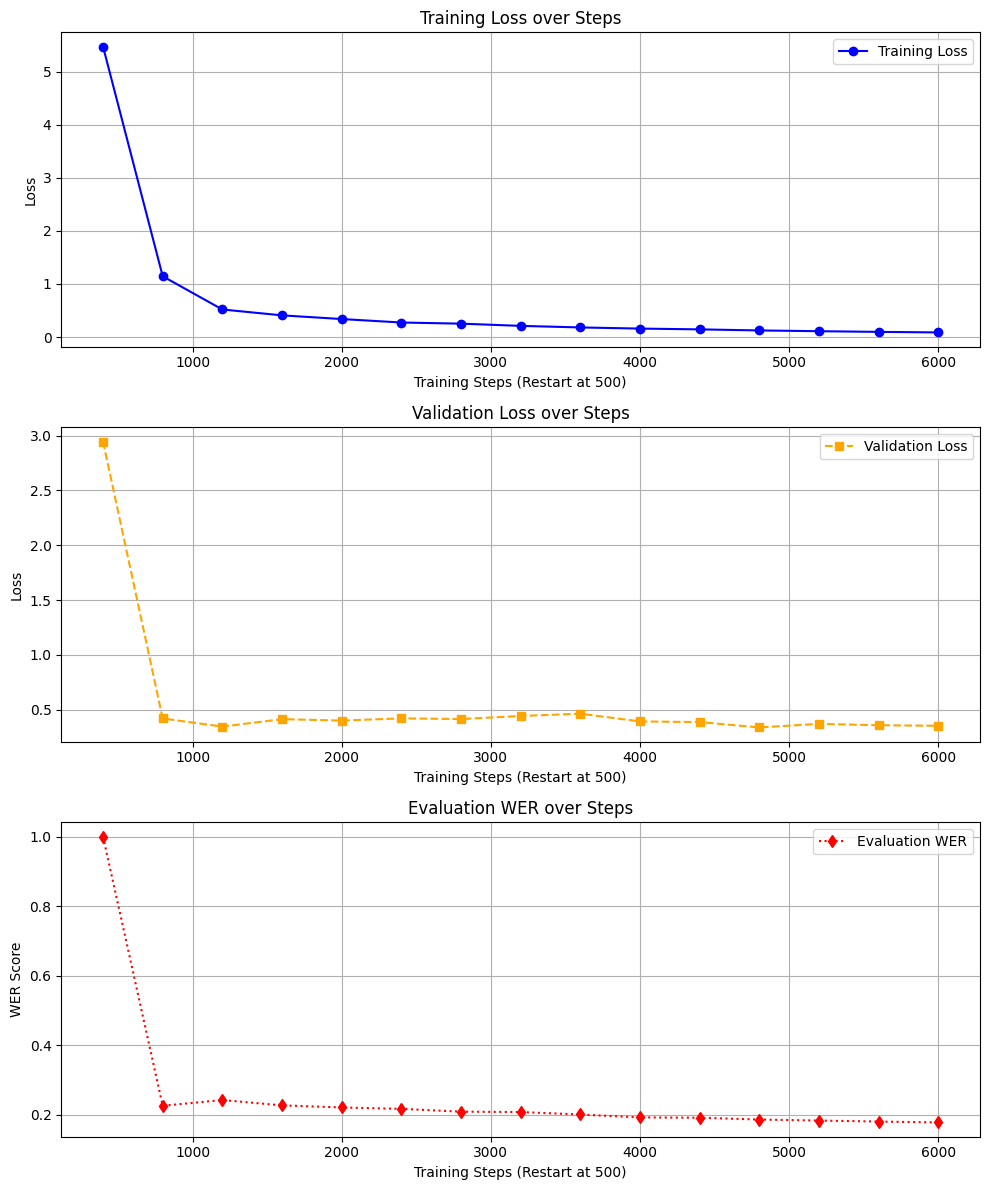

In [ ]:
# Plot train loss, eval loss and WER scores across steps
def plot_metrics(model_dir):
    """
    Plots training loss, validation loss, and evaluation WER over training steps.
    """
    # Extract state file from saved checkpoint
    state_file = os.path.join(model_dir, "trainer_state.json")

    # Load JSON file
    with open(state_file, "r") as f:
        trainer_state = json.load(f)

    # Extract log history
    log_history = trainer_state.get("log_history", [])

    # Convert to DataFrame
    log_df = pd.DataFrame(log_history)

    # Extract relevant metrics while removing NaNs
    train_loss = log_df["loss"].dropna().values
    eval_loss = log_df["eval_loss"].dropna().values if "eval_loss" in log_df.columns else None
    eval_wer = log_df["eval_wer"].dropna().values if "eval_wer" in log_df.columns else None

    # Generate step labels restarting at 400 for each chart
    train_steps = np.arange(400, (len(train_loss) + 1) * 400, 400)
    eval_steps = np.arange(400, (len(eval_loss) + 1) * 400, 400) if eval_loss is not None else None
    wer_steps = np.arange(400, (len(eval_wer) + 1) * 400, 400) if eval_wer is not None else None

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot Training Loss
    axs[0].plot(train_steps, train_loss, label="Training Loss", marker="o", linestyle="-", color="blue")
    axs[0].set_title("Training Loss over Steps")
    axs[0].set_xlabel("Training Steps (Restart at 500)")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()

    # Plot Evaluation Loss (if available)
    if eval_loss is not None:
        axs[1].plot(eval_steps, eval_loss, label="Validation Loss", marker="s", linestyle="--", color="orange")
        axs[1].set_title("Validation Loss over Steps")
        axs[1].set_xlabel("Training Steps (Restart at 500)")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid()

    # Plot Evaluation WER (if available)
    if eval_wer is not None:
        axs[2].plot(wer_steps, eval_wer, label="Evaluation WER", marker="d", linestyle=":", color="red")
        axs[2].set_title("Evaluation WER over Steps")
        axs[2].set_xlabel("Training Steps (Restart at 500)")
        axs[2].set_ylabel("WER Score")
        axs[2].legend()
        axs[2].grid()

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

# Plot.
model_dir = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/wav2vec2-large-960h-cv"
plot_metrics(model_dir)

### Run inference transcriptions on "cv-valid-test" audio files and save generated text in "cv-valid-test.csv" with saved model

In [ ]:
# Test transcription with loaded model and processor - load.
model_path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/wav2vec2-large-960h-cv"

# Define processor and model
processor = Wav2Vec2Processor.from_pretrained(model_path)
model = Wav2Vec2ForCTC.from_pretrained(model_path)

# Define audio file path
audio_path = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-test/sample-000011.mp3"

# Load audio file
waveform, sr = torchaudio.load(audio_path)

# Ensure correct sampling rate
if sr != 16000:
    resampler = torchaudio.transforms.Resample(sr, 16000)
    waveform = resampler(waveform)

# flatten waveform
waveform = waveform.squeeze()

# Process the audio input
inputs = processor(waveform.numpy(), sampling_rate=16000, return_tensors="pt")

# Perform inference with the model
with torch.no_grad():
    logits = model(**inputs).logits

# Decode prediction
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(predicted_ids[0], group_tokens=True)

print("Transcription:", transcription)

Transcription: they made the boy continue digging but he found nothing


In [ ]:
# Set device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load fine-tuned model and processor
model_dir = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/wav2vec2-large-960h-cv"
processor = Wav2Vec2Processor.from_pretrained(model_dir)
model = Wav2Vec2ForCTC.from_pretrained(model_dir).to(device)

# Load CSV containing filenames
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-baseline.csv"
if not os.path.isfile(csv_file):
    raise FileNotFoundError(f"Error: '{csv_file}' not found.")

df = pd.read_csv(csv_file)
print(f"Loaded {len(df)} rows from '{csv_file}'.")

def process_audio(audio_path):
    """Loads and preprocesses an individual audio file for transcription."""
    try:
        with open(audio_path, "rb") as f:
            audio_bytes = f.read()

        # Decode audio
        audio, sr = torchaudio.load(io.BytesIO(audio_bytes), format="mp3")

        # Resample to 16 kHz if needed
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(sr, 16000)
            audio = resampler(audio)

        # Convert multi-channel to mono if necessary
        if audio.ndim > 1 and audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0)

        return audio.squeeze(0)  # Remove extra dimensions

    except Exception as e:
        print(f"Error processing '{audio_path}': {e}")
        return None  # Return None if processing fails

def transcribe_audio(audio_tensor):
    """Transcribes a single audio file using the model."""
    inputs = processor(audio_tensor, sampling_rate=16000, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(inputs.input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])

# Process audio files one by one
transcriptions = []

for _, row in tqdm(df.iterrows(), desc="Processing audio files", total=len(df)):
    file_name = row.get("filename", "")
    if not file_name:
        transcriptions.append("")
        continue

    audio_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune", file_name)
    if not os.path.isfile(audio_path):
        print(f"Warning: File '{audio_path}' not found. Skipping.")
        transcriptions.append("")
        continue

    audio_tensor = process_audio(audio_path)
    if audio_tensor is None:
        transcriptions.append("")
        continue

    try:
        text = transcribe_audio(audio_tensor)
        transcriptions.append(text)
    except Exception as e:
        print(f"Error transcribing '{audio_path}': {e}")
        transcriptions.append("")

# Save transcriptions to new CSV file
df["generated_text6300"] = transcriptions
new_filename = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-6300.csv"
df.to_csv(new_filename, index=False)
print(f"Updated '{new_filename}' with transcriptions.")

Loaded 4076 rows from '/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-baseline.csv'.


Processing audio files: 100%|██████████| 4076/4076 [38:47<00:00,  1.75it/s]

Updated '/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-6300.csv' with transcriptions.


### Word Error Rate (WER) performance for Wav2Vec2 models on "cv-valid-test" dataset & "cv-valid-dev" dataset
- Load WER scores from inference datasets (baseline pretrained, finetune2000 & finetune6300)
- Plot categorical plots to illustrate WER scores across "accent".

#### Results:
- WER of fine-tuned model (2,000 datapoints) on test set was approximately 12%, a significant improvement from evaluation WER at 2,400 steps (21.9%)
- WER of fine-tuned model (6,300 datapoints) on test set was approximately 7.3%, a significant improvement from evaluation WER at 6,000 steps (17.8%)

In [ ]:
# Load WER metric
wer_metric = evaluate.load("wer")

def compute_wer_from_csv(csv_path):
    """
    Compute the Word Error Rate (WER) between the actual text and predicted transcriptions
    from a CSV file. Converts text to lowercase before computing WER.
    """
    # Load dataset
    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    if "text" not in df.columns or "generated_text" not in df.columns:
        raise ValueError("CSV file must contain 'text' (ground truth) and 'generated_text' (predictions) columns.")

    # Convert text to lowercase
    df["text"] = df["text"].str.lower()
    df["generated_text"] = df["generated_text"].str.lower()

    # Compute WER
    wer_score = wer_metric.compute(predictions=df["generated_text"].tolist(), references=df["text"].tolist())

    return wer_score

In [ ]:
# Evaluate "cv-valid-dev" on WER for API inferencing
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-baseline.csv"
wer_result = compute_wer_from_csv(csv_file)
print(f"Baseline (dev set) WER: {wer_result:.4f}")

Baseline (dev set) WER: 0.1081


In [ ]:
# Evaluate "cv-valid-test2000" on WER for API inferencing
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-test-transcribed2000.csv"
wer_result = compute_wer_from_csv(csv_file)
print(f"Fine-tuned 2000 (test set) WER: {wer_result:.4f}")

Fine-tuned 2000 (test set) WER: 0.1204


In [ ]:
# Evaluate "cv-valid-test6300" on WER for API inferencing
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-test-transcribed6300.csv"
wer_result = compute_wer_from_csv(csv_file)
print(f"Fine-tuned 6300 (test set) WER: {wer_result:.4f}")

Fine-tuned 6300 (test set) WER: 0.0727


In [ ]:
# Evaluate "cv-valid-dev-6300" on WER for API inferencing
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-6300.csv"
wer_result = compute_wer_from_csv(csv_file)
print(f"Fine-tuned 6300 (dev set) WER: {wer_result:.4f}")

Fine-tuned 6300 (dev set) WER: 0.0772


#### Plot WER scores across key features "accent", "gender" and "age"

In [ ]:
# Load WER metric
wer_metric = evaluate.load("wer")

def compute_wer_and_plot(csv_path, category_column):
    """
    Compute the Word Error Rate (WER) for the overall dataset and across
    a specified categorical column. Returns a bar plot of WER scores grouped
    by the categorical variable.
    """
    # Load dataset
    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_columns = {"text", "generated_text6300", category_column}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"CSV file must contain columns: {required_columns}")

    # Convert text to lowercase
    df["text"] = df["text"].str.lower()
    df["generated_text6300"] = df["generated_text6300"].str.lower()

    # Compute overall WER
    overall_wer = wer_metric.compute(predictions=df["generated_text6300"].tolist(),
                                     references=df["text"].tolist())

    print(f"Overall WER: {overall_wer:.4f}")

    # Compute WER for each category
    wer_by_category = {}
    for category, group in df.groupby(category_column):
        wer = wer_metric.compute(predictions=group["generated_text6300"].tolist(),
                                 references=group["text"].tolist())
        wer_by_category[category] = wer

    # Convert to DataFrame for plotting
    wer_df = pd.DataFrame(list(wer_by_category.items()), columns=[category_column, "WER Score"])

    # Plot WER scores across categories
    plt.figure(figsize=(10, 5))
    sns.barplot(x=category_column, y="WER Score", data=wer_df, palette="viridis")
    plt.title(f"WER Scores by {category_column} (fine-tuned)")
    plt.ylabel("Word Error Rate (WER)")
    plt.xlabel(category_column)
    plt.xticks(rotation=45)
    plt.ylim(0, max(wer_by_category.values()) * 1.1)  # Add some padding
    plt.show()

Overall WER: 0.1081


<ipython-input-8-2bb113a6e360>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_column, y="WER Score", data=wer_df, palette="viridis")


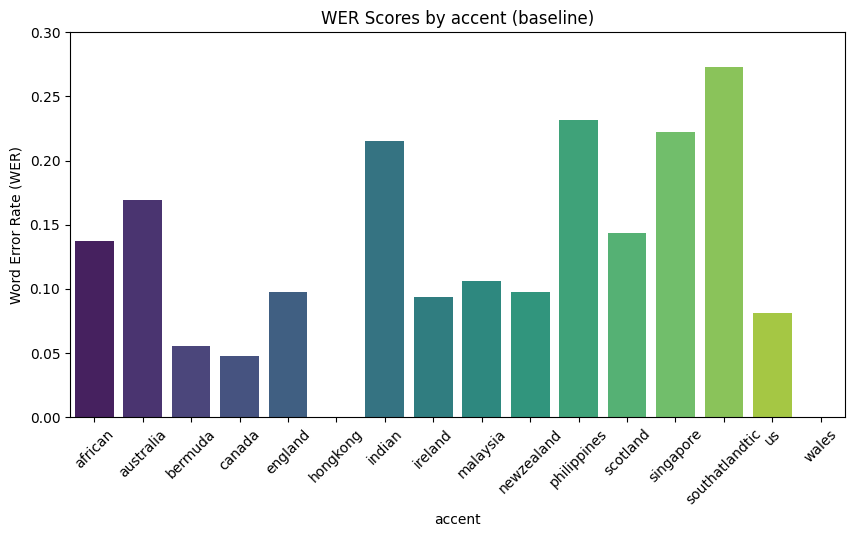

In [ ]:
# Baseline model
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-baseline.csv"
compute_wer_and_plot(csv_file, "accent")

Overall WER: 0.1204


<ipython-input-5-ade32b660654>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_column, y="WER Score", data=wer_df, palette="viridis")


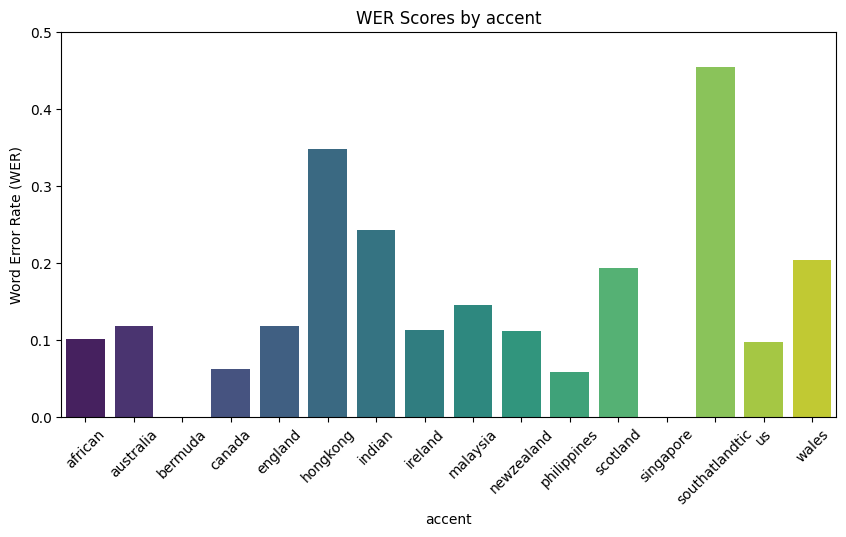

In [ ]:
# Fine-tuned 2,000 model
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-test-transcribed2000.csv"
compute_wer_and_plot(csv_file, "accent")

Overall WER: 0.0772


<ipython-input-12-bb2cafc77bd9>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_column, y="WER Score", data=wer_df, palette="viridis")


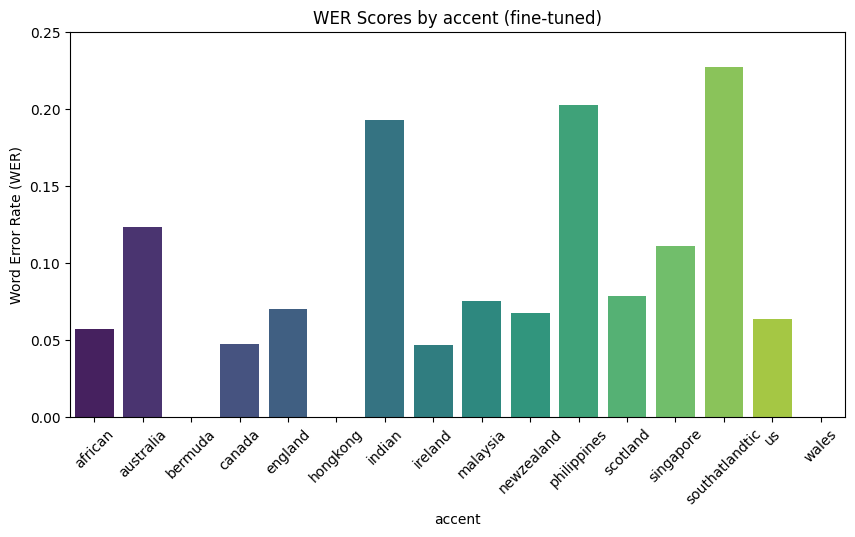

In [ ]:
# Fine-tuned 6,300 model
csv_file = "/content/drive/MyDrive/Colab Notebooks/wav2vec2-finetune/cv-valid-dev-6300.csv"
compute_wer_and_plot(csv_file, "accent")